# Replication of attack on VoIP end-to-end encrypted messengers

## Loading dataset

First we will try to load our data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()  # make plots nicer

np.random.seed(42)  # set seed for reproducibility

Format of the input file is as follows (with examples of data, that can be there):  
**Line indicating spoken phrase:** _Sentence: "She had your dark suit in greasy wash water all year."_  
**Line with information about current transmission** _Packets: 146, Samples: 46797, Samples per packet: 320_  
**Line with data**: _74;ix,hv;"she","had"_ (packet size, phonemes, words)

In [2]:
# data format: name (of csv file); sentence; (packet size, [phonems], [words])
def file_parser(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_type = path.split("-")[2]
    sentence = ""
    file_data = []
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            #TODO
            
            line += [""]
            line += [""]
            continue
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            if (line[1] == 'h#'):
                continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
           
        # file_type and sentence contain duplicate informations, but are kept for readability
        line = [path.split('/')[3]] + [sentence] + line
        file_data += [line]

    return pd.DataFrame(file_data, columns=['file', 'sentence', 'packet_size', 'phonemes', 'words'])

def load_files(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

In [3]:
#file_parser("./data/whatsapp_train_data/DR1-FSAH0-SI614.CSV")   

data = load_files("./data/skype_train_data/")
data

,file,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,54,"(h#, sh)","(she,)"
1,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,66,"(sh,)","(she,)"
2,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,70,"(sh,)","(she,)"
3,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,72,"(sh,)","(she,)"
4,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,65,"(sh,)","(she,)"
...,...,...,...,...,...
623607,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,64,"(s,)","(tips,)"
623608,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,"(s,)","(tips,)"
623609,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,"(s,)","(tips,)"
623610,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,59,"(s,)","(tips,)"


For our purposes we've decided to omit beggings and ends of the files as they contain only some silence. Maybe it would be worth investigating what the accuracy would be, had we not remowed these.

Let's convert the `packet_size` from _object_ to _numerical value_ and `file`, `sentence` to the type _category_.

In [4]:
data['packet_size'] = pd.to_numeric(data['packet_size'])

In [5]:
data['file'] = data['file'].astype('category')
data['sentence'] = data['sentence'].astype('category')

In [6]:
data.dtypes

file           category
sentence       category
packet_size       int64
phonemes         object
words            object
dtype: object

## Exploratory analysis

For most of our exploratory analysis we will use the powerfull tool of `pandas_profilling` which can provide us with many interesting graphs and statistics, which we can use.

Our first step in exploratory analysis will be to just to look at data without modifying anything (expect the column types)

In [7]:
import pandas_profiling as pp
from pandas_profiling import ProfileReport

ProfileReport(data, "First look at data")

From this analysis we can see, that we have 4620 distinct files (which isn't surprising, we already knew that) and 1737 unique sentences. Sadly `pandas_profilling` doesn't seem to be up to this task as converting phonemes and words to cathegorical values breaks `pandas_profilling`. This is caused by current implementation of `pandas` that requires categorical list like objects to be of the same length so it can do the comparison (_categorical.py in func(self, other), lines 70 to 72_).

Now we will get the frequencies of senteces.

In [8]:
frequencies = data[['sentence', 'file']].drop_duplicates(subset=['file'])['sentence'].value_counts()
frequencies

She had your dark suit in greasy wash water all year.                         462
Don't ask me to carry an oily rag like that.                                  461
Growing well-kept gardens is very time consuming.                               7
Correct execution of my instructions is crucial.                                7
Cyclical programs will never compile.                                           7
                                                                             ... 
Sprouted grains and seeds are used in salads and dishes such as chop suey.      1
State numbering laws differ from each other in many ways.                       1
Stay right here where you are, kid, he called.                                  1
Stoneware clay for tiles.                                                       1
"Cable confirmation", it said translated.                                       1
Name: sentence, Length: 1737, dtype: int64

In [9]:
np.asarray(np.unique(frequencies.array.to_numpy(), return_counts=True)).T

array([[   1, 1402],
       [   2,    3],
       [   4,    1],
       [   5,    2],
       [   6,   14],
       [   7,  313],
       [ 461,    1],
       [ 462,    1]], dtype=int64)

We can see, that the sentence column is heavily skewed as 30% of our dataset is composed of sentences, which are spoken only once. 10% takes the sentence _She had your dark suit in greasy wash water all year._ and another 10% takes sentence _Don't ask me to carry an oily rag like that._ The remaining 50% of the data are sentences, that have more than one occurance, but not by a high margin.

Now we can properly convert words and phonemes to their proper type -> category

In [10]:
# this conversion breaks pandas_profiling :(
# actually I know why this breaks profilling, pandas requieres categorical list like structures to be of the same length for reasons unknown
data['phonemes'] = data['phonemes'].astype('category')
data['words'] = data['words'].astype('category')

### Statistic for packet sizes for specific phonemes / words

Now let's look at packet sizes for few select words / phonemes. From the first look at data I would say, that packet sizes for phonemes will be more important for the `skype` dataset and packet sizes for words will be more important for `whatsapp` dataset.<br />
This is because `skype` dataset uses much smaller packet sizes, therefore it is highly probable, that only one phoneme will correspond to only one packet size and the same goes for `whatsapp` dataset, that has much bigger packets and from my observation one packet corresponds to one word.

In [11]:
label_data = data.loc[:, ('packet_size', 'phonemes', 'words', 'sentence')]
label_data

,packet_size,phonemes,words,sentence
0,54,"(h#, sh)","(she,)",She had your dark suit in greasy wash water al...
1,66,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
2,70,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
3,72,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
4,65,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
...,...,...,...,...
623607,64,"(s,)","(tips,)",Good service should be rewarded by big tips.
623608,63,"(s,)","(tips,)",Good service should be rewarded by big tips.
623609,63,"(s,)","(tips,)",Good service should be rewarded by big tips.
623610,59,"(s,)","(tips,)",Good service should be rewarded by big tips.


In [12]:
len(pd.unique(label_data['phonemes']))

3081

In [13]:
len(pd.unique(label_data['words']))

15713

From this we can see, that we have 3081 unique n-grams of phonemes and 15713 unique n-grams of words.

#### Phonemes

Now we will look at the top most occuring phonemes and define analysis for specific phonemes / words:

In [14]:
label_frequencies = label_data['phonemes'].value_counts()
label_frequencies.head(20)

(s,)      34535
(ae,)     25557
(iy,)     24409
(aa,)     15627
(ao,)     15233
(ay,)     14780
(ih,)     14750
(eh,)     13669
(ix,)     13497
(r,)      13192
(ey,)     12160
(n,)      11982
(z,)      11908
(kcl,)    11581
(l,)      11553
(tcl,)    11412
(ow,)     11284
(sh,)     10634
(axr,)    10402
(er,)      9931
Name: phonemes, dtype: int64

In [15]:
from IPython.display import display

def get_distribution_info(dataframe, xlabel):
    Q1 = dataframe.packet_size.quantile(0.25)
    Q3 = dataframe.packet_size.quantile(0.75)
    IQR = Q3 - Q1

    print("Current label:\t\t", xlabel)
    print("Total values:", dataframe.packet_size.count())
    print("Lower outsiders:", (dataframe.packet_size < (Q1 - 1.5 * IQR)).sum())
    print("Upper outsiders:", (dataframe.packet_size > (Q3 + 1.5 * IQR)).sum())
    print()
    
    plt.figure()
    dataframe.packet_size.plot.box()
    plt.xlabel(xlabel)
    plt.show()
    plt.figure()
    dataframe.packet_size.plot.hist()
    plt.show()

    #display(dataframe[dataframe.packet_size < (Q1 - 1.5 * IQR)].sort_values('packet_size').head(10))
    #display(dataframe[dataframe.packet_size > (Q3 + 1.5 * IQR)].sort_values('packet_size', ascending=False).head(10))
    
    display(dataframe.sort_values('packet_size').head(10))
    display(dataframe.sort_values('packet_size', ascending=False).head(10))

We will take a look at a few of the most common phonemes (and the most common pair of phonemes) and see whether they are evenly distributed or not at all:

Current label:		 ('s',)
Total values: 34535
Lower outsiders: 170
Upper outsiders: 702



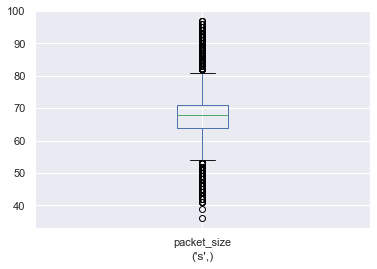

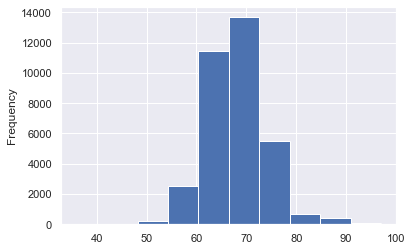

,packet_size,phonemes,words,sentence
566043,36,"(s,)","(audience,)","As coauthors, we presented our new book to the..."
228933,39,"(s,)","(square,)",While waiting for Chipper she crisscrossed the...
316074,41,"(s,)","(miraculous,)",The new birth is miraculous and mysterious.
553850,41,"(s,)","(unions,)",It was most effective against trade unions.
12011,41,"(s,)","(coexist,)",Curiosity and mediocrity seldom coexist.
324233,41,"(s,)","(exquisite,)",Vietnamese cuisine is exquisite.
30906,42,"(s,)","(regulations,)",Etiquette mandates compliance with existing re...
70292,42,"(s,)","(offensive,)",Nothing is as offensive as innocence.
82909,42,"(s,)","(coincided,)",Employee layoffs coincided with the company's ...
245615,42,"(s,)","(ask,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
131977,97,"(s,)","(zoologist,)",The easygoing zoologist relaxed throughout the...
334598,97,"(s,)","(progress,)",Scientific progress comes from the development...
72266,97,"(s,)","(strip,)",A smile pulled at the lower strip of adhesive ...
123976,96,"(s,)","(exist,)","Mosquitoes exist in warm, humid climates."
621173,96,"(s,)","(fibrosis,)","Microscopically, there was emphysema, fibrosis..."
323831,96,"(s,)","(snarled,)",She snarled warningly.
482358,96,"(s,)","(ambidextrous,)",Ambidextrous pickpockets accomplish more.
83817,96,"(s,)","(lists,)",The data are presented in lists and tables.
177324,95,"(s,)","(mathews,)","Davy Mathews! It's disgusting, the way you're ..."
594392,95,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...




Current label:		 ('ae',)
Total values: 25557
Lower outsiders: 96
Upper outsiders: 31



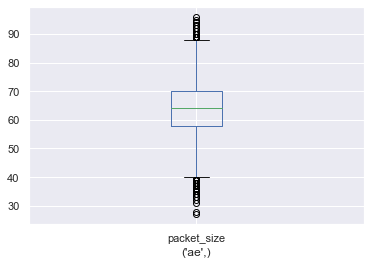

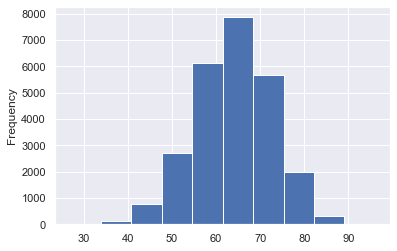

,packet_size,phonemes,words,sentence
20517,27,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
349205,28,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
298783,31,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
360424,32,"(ae,)","(rag,)",Don't ask me to carry an oily rag like that.
317207,33,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
525757,33,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
346086,34,"(ae,)","(mask,)",The prowler wore a ski mask for disguise.
485743,34,"(ae,)","(man,)",For a man of his mass he was curiously short.
262136,34,"(ae,)","(hand,)",Publicity and notoriety go hand in hand.
375289,35,"(ae,)","(rag,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
302591,96,"(ae,)","(ask,)",Don't ask me to carry an oily rag like that.
417794,95,"(ae,)","(ask,)",Don't ask me to carry an oily rag like that.
489348,94,"(ae,)","(lack,)",The lack of heat compounded the tenant's griev...
168880,94,"(ae,)","(wagons,)",The wagons were burning fiercely.
353275,93,"(ae,)","(trespassing,)",Trespassing is forbidden and subject to penalty.
423712,93,"(ae,)","(laboratory,)",Thirty-five military and civilian students rec...
329151,92,"(ae,)","(ask,)",Don't ask me to carry an oily rag like that.
110368,92,"(ae,)","(nevada,)",Brush fires are common in the dry underbrush o...
571847,92,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
206409,91,"(ae,)","(rag,)",Don't ask me to carry an oily rag like that.




Current label:		 ('iy',)
Total values: 24409
Lower outsiders: 75
Upper outsiders: 35



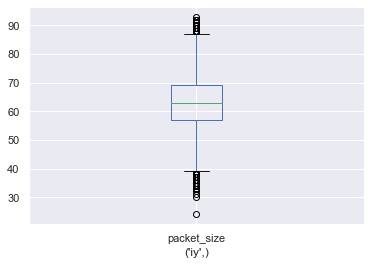

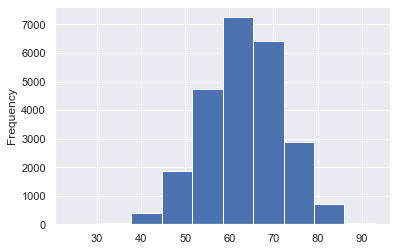

,packet_size,phonemes,words,sentence
147996,24,"(iy,)","(freely,)",Remember to allow identical twins to enter fre...
306147,30,"(iy,)","(mediocrity,)",Curiosity and mediocrity seldom coexist.
486630,31,"(iy,)","(cheese,)",First add milk to the shredded cheese.
499129,32,"(iy,)","(received,)",Al received a joint appointment in the biology...
471814,33,"(iy,)","(cream,)",Birthday parties have cupcakes and ice cream.
353697,33,"(iy,)","(cheese,)",We like bleu cheese but Victor prefers swiss c...
365102,33,"(iy,)","(needs,)",He needs outfielders bad.
163036,33,"(iy,)","(forgery,)",It's hard to tell an original from a forgery.
486629,33,"(iy,)","(cheese,)",First add milk to the shredded cheese.
174945,34,"(iy,)","(eating,)","By eating yogurt, you may live longer."


,packet_size,phonemes,words,sentence
440414,93,"(iy,)","(increases,)",Last year's gas shortage caused steep price in...
110159,92,"(iy,)","(norwegian,)",Norwegian sweaters are made of lamb's wool.
591031,92,"(iy,)","(carry,)",Don't ask me to carry an oily rag like that.
300001,92,"(iy,)","(me,)",Don't ask me to carry an oily rag like that.
445851,92,"(iy,)","(recoiled,)",The barracuda recoiled from the serpent's pois...
217961,91,"(iy,)","(legal,)",Mike was of legal age and presumed able to def...
87922,91,"(iy,)","(oily,)",Don't ask me to carry an oily rag like that.
256035,90,"(iy,)","(greasy,)",She had your dark suit in greasy wash water al...
187700,90,"(iy,)","(eating,)","By eating yogurt, you may live longer."
210319,90,"(iy,)","(cory,)",Cory attacked the project with extra determina...




Current label:		 ('kcl', 'k')
Total values: 4488
Lower outsiders: 0
Upper outsiders: 11



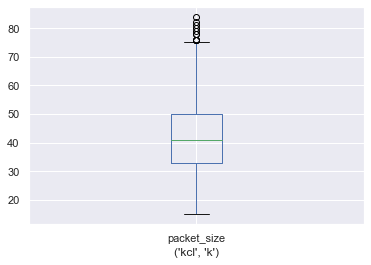

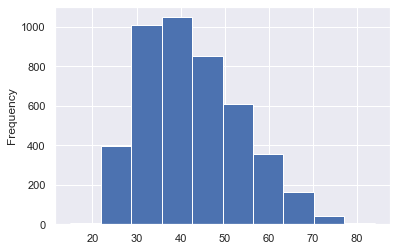

,packet_size,phonemes,words,sentence
100003,15,"(kcl, k)","(clothes,)",She must have put his clothes in the closet.
109943,20,"(kcl, k)","(scalp,)",His scalp was blistered from today's hot sun.
101045,20,"(kcl, k)","(ask,)",Don't ask me to carry an oily rag like that.
576143,20,"(kcl, k)","(walked,)",Samples: he walked in upon her invitation.
511884,21,"(kcl, k)","(perpendicular,)","According to my interpretation of the problem,..."
251813,21,"(kcl, k)","(ask,)",Don't ask me to carry an oily rag like that.
134189,21,"(kcl, k)","(carry,)",Don't ask me to carry an oily rag like that.
32515,21,"(kcl, k)","(make,)",Make it come off all right.
192374,21,"(kcl, k)","(grotesque,)","It was a grotesque hen, five or six feet tall."
268358,22,"(kcl, k)","(check,)",It's illegal to postdate a check.


,packet_size,phonemes,words,sentence
271487,84,"(kcl, k)","(think,)",You think somebody is going to stand up in the...
181613,82,"(kcl, k)","(toxic,)","In developing film, many toxic chemicals are u..."
484558,81,"(kcl, k)","(cooperates,)",Whoever cooperates in finding Nan's cameo will...
535595,80,"(kcl, k)","(coeducational,)",Almost all colleges are now coeducational.
96290,79,"(kcl, k)","(coeducational,)",Almost all colleges are now coeducational.
312390,78,"(kcl, k)","(dark,)",She had your dark suit in greasy wash water al...
150754,78,"(kcl, k)","(clamp,)",Thomas thinks a larger clamp solves the problem.
139754,76,"(kcl, k)","(eccentricity,)",He had accordingly cultivated eccentricity to ...
549717,76,"(kcl, k)","(continuing,)",The continuing modernization of these forces i...
42780,76,"(kcl, k)","(dark,)",She had your dark suit in greasy wash water al...


In [16]:
label_data['phonemes'] = label_data['phonemes'].astype('object')

interesting_phonemes = [("s",), ("ae",), ("iy",), ("kcl", "k")]

for phoneme in interesting_phonemes:
    graph_data = label_data.loc[label_data.phonemes == phoneme]
    get_distribution_info(graph_data, phoneme)
    print('\n')

#graph_data['phonemes'] = label_data['phonemes'].astype('category')
label_data['phonemes'] = label_data['phonemes'].astype('category')

From these graphs we can already see a few alarming things. First of all the phonemes sizes are all over the place suggesting, that there shouldn't be much a a correlation between packet size and spoken phonemes. We will try to make further observations taking into account the surrounding phonemes as that should prove more fruitfull than only focusing on phonemes alone.

#### Words

In [17]:
label_frequencies = label_data['words'].value_counts()
label_frequencies.head(20)

(,)          11884
(that,)       9286
(greasy,)     8543
(wash,)       8161
(carry,)      7913
(suit,)       7656
(rag,)        7526
(oily,)       7367
(dark,)       7344
(year,)       7241
(water,)      7049
(ask,)        6178
(she,)        5579
(like,)       5553
(the,)        5508
(had,)        5458
(all,)        5321
(in,)         5263
(don't,)      4576
(to,)         4475
Name: words, dtype: int64

Current label:		 ('',)
Total values: 11884
Lower outsiders: 0
Upper outsiders: 93



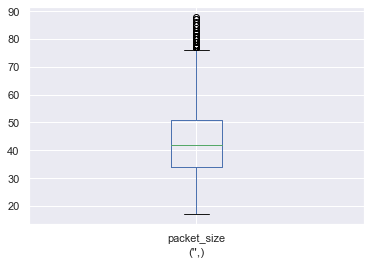

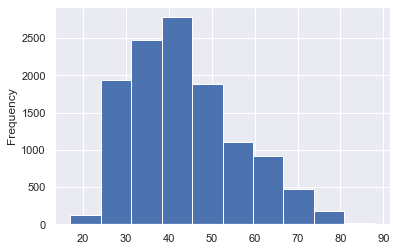

,packet_size,phonemes,words,sentence
180891,17,"(epi,)","(,)",Don't ask me to carry an oily rag like that.
486232,19,"(pau,)","(,)","Draw every outer line first, then fill in the ..."
35005,19,"(pau,)","(,)",We will achieve a more vivid sense of what it ...
336018,20,"(pau,)","(,)","Below is a specific guide, keyed to the calendar."
192060,20,"(epi,)","(,)",Don't ask me to carry an oily rag like that.
454281,20,"(epi,)","(,)",It has multiple implications and possible head...
255149,20,"(pau,)","(,)",Push back up and repeat.
316079,21,"(pau,)","(,)",The new birth is miraculous and mysterious.
255323,21,"(pau,)","(,)",Our experiment's positive outcome was unexpected.
372463,21,"(pau,)","(,)",Lousiness is a prerequisite for epidemic typhus.


,packet_size,phonemes,words,sentence
77476,88,"(q,)","(,)",She had your dark suit in greasy wash water al...
424196,87,"(q,)","(,)",They often go out in the evening.
83594,87,"(q,)","(,)",She had your dark suit in greasy wash water al...
291226,86,"(q,)","(,)",Correct execution of my instructions is crucial.
244183,85,"(q,)","(,)",She had your dark suit in greasy wash water al...
386095,85,"(q,)","(,)","Draw every outer line first, then fill in the ..."
203411,85,"(q,)","(,)",Women may never become completely equal to men.
444794,85,"(q,)","(,)",She had your dark suit in greasy wash water al...
117626,84,"(pau,)","(,)",Westchester is a county in New York.
37686,83,"(q,)","(,)",Her auburn hair reminded him of autumn leaves.




Current label:		 ('that',)
Total values: 9286
Lower outsiders: 0
Upper outsiders: 0



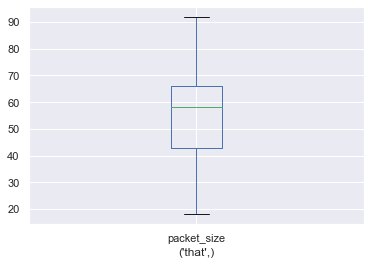

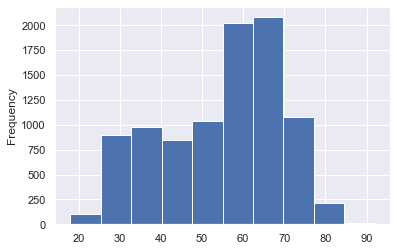

,packet_size,phonemes,words,sentence
522576,18,"(dh,)","(that,)",The proof that you are seeking is not availabl...
444250,20,"(tcl,)","(that,)",Count the number of teaspoons of soysauce that...
58601,21,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
414427,21,"(tcl, t)","(that,)",Don't ask me to carry an oily rag like that.
259059,21,"(tcl,)","(that,)",Don't ask me to carry an oily rag like that.
172924,21,"(ae, tcl)","(that,)",Don't ask me to carry an oily rag like that.
617102,21,"(tcl,)","(that,)",Don't ask me to carry an oily rag like that.
195877,22,"(q, h#)","(that,)",Don't ask me to carry an oily rag like that.
61273,22,"(dh,)","(that,)",Don't ask me to carry an oily rag like that.
513973,22,"(tcl,)","(that,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
571847,92,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
160515,90,"(ae,)","(that,)",You could also say that in these pamphlets is ...
300089,89,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
134262,88,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
26777,88,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
39328,87,"(ae,)","(that,)",I'll have a scoop of that exotic purple and tu...
233322,87,"(dh, ae)","(that,)",Did Shawn catch that big goose without help?
256195,87,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
294926,87,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
600665,86,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.




Current label:		 ('greasy',)
Total values: 8543
Lower outsiders: 365
Upper outsiders: 34



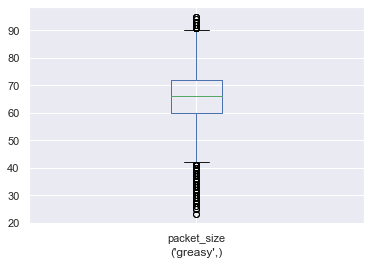

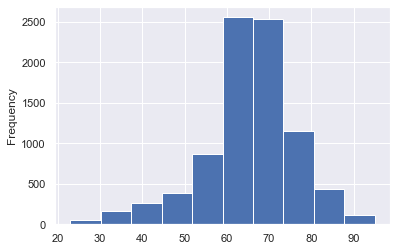

,packet_size,phonemes,words,sentence
239916,23,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
264065,23,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
499743,25,"(gcl,)","(greasy,)",She had your dark suit in greasy wash water al...
75783,25,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
245521,25,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
291986,26,"(gcl,)","(greasy,)",She had your dark suit in greasy wash water al...
333683,26,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
124659,27,"(gcl,)","(greasy,)",She had your dark suit in greasy wash water al...
266833,27,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
86295,27,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
594392,95,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...
586743,95,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
167184,95,"(ix, s)","(greasy,)",She had your dark suit in greasy wash water al...
247924,94,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...
246744,94,"(z,)","(greasy,)",She had your dark suit in greasy wash water al...
145856,93,"(iy, z)","(greasy,)",She had your dark suit in greasy wash water al...
323643,93,"(z,)","(greasy,)",She had your dark suit in greasy wash water al...
414194,93,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
203675,93,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...
481266,93,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...




Current label:		 ('had', 'your')
Total values: 895
Lower outsiders: 54
Upper outsiders: 2



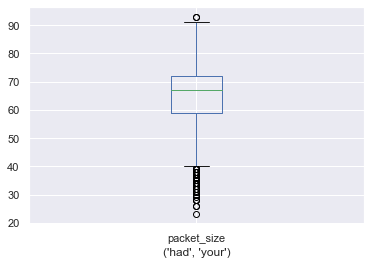

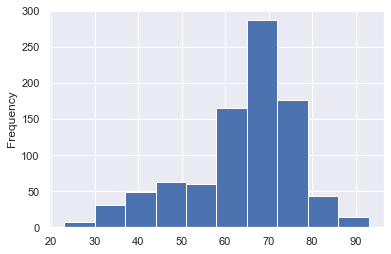

,packet_size,phonemes,words,sentence
239864,23,"(dcl, y)","(had, your)",She had your dark suit in greasy wash water al...
161698,26,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
291930,26,"(dcl, ch)","(had, your)",She had your dark suit in greasy wash water al...
160179,28,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
550767,28,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
22818,28,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
19042,29,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
51539,30,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
33543,30,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
565145,31,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
95562,93,"(d, y)","(had, your)",She had your dark suit in greasy wash water al...
447993,93,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
171241,91,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
123263,91,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
218900,90,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
407360,89,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
567650,89,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
150938,87,"(d, y)","(had, your)",She had your dark suit in greasy wash water al...
282131,87,"(jh, axr)","(had, your)",She had your dark suit in greasy wash water al...
471219,87,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...


In [18]:
label_data['words'] = label_data['words'].astype('object')

interesting_words = [("",), ("that",), ("greasy",), ("had", "your")]

for word in interesting_words:
    graph_data = label_data.loc[label_data.words == word]
    #graph_data = graph_data.copy() #.loc was somehow acting up and not copying properly
    get_distribution_info(graph_data, word)
    print('\n')

label_data['phonemes'] = label_data['phonemes'].astype('category')

We can see, that the distribution is still all over the place, but more concise than for phonemes, which is kinda surprising. But the problem here is that for longer words we have multiple packets that corespond to said word.

### Feature engineering

Our current analysises so far have only taken into account packet_size alone. Now we will foccus on surrounding packet sizes so we can deduce much more information about our packet sizes and their correspondence to phonemes / words.  
So let's look at data once again:

In [19]:
data

,file,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,54,"(h#, sh)","(she,)"
1,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,66,"(sh,)","(she,)"
2,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,70,"(sh,)","(she,)"
3,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,72,"(sh,)","(she,)"
4,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,65,"(sh,)","(she,)"
...,...,...,...,...,...
623607,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,64,"(s,)","(tips,)"
623608,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,"(s,)","(tips,)"
623609,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,"(s,)","(tips,)"
623610,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,59,"(s,)","(tips,)"


We will modify our file parsing function to add previous and next packet size to each record.

In [20]:
def file_parser_with_prev_next(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_type = path.split("-")[2]
    sentence = ""
    file_data = []
    
    has_value = False
    previous = 0
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            #TODO
            line += [""]
            line += [""]
            continue
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            #potentionally harmfull as we shouldn't clean test data this way (we will be reading labels)
            if (line[1] == 'h#'):
                continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
        
        if (has_value):
            file_data[-1][3] = line[0]
           
        # file_type and sentence contain duplicate informations, but are kept for readability
        line = [path.split('/')[3]] + [sentence] + [previous] + [0] + line
        #adding previous as feature
        previous = line[4]
        file_data += [line]
        
        #adding next frame as feature
        has_value = True
        
        

    return pd.DataFrame(file_data, columns=['file', 'sentence', 'previous_packet', 'next_packet','packet_size', 'phonemes', 'words'])

def load_files_with_prev_next(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser_with_prev_next(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

In [21]:
def convert_types(data_frame):
    data_frame['packet_size'] = pd.to_numeric(data_frame['packet_size'])
    data_frame['previous_packet'] = pd.to_numeric(data_frame['previous_packet'])
    data_frame['next_packet'] = pd.to_numeric(data_frame['next_packet'])

    data_frame['file'] = data_frame['file'].astype('category')
    data_frame['sentence'] = data_frame['sentence'].astype('category')

First we will be trying to explore Skype data set as the aproach, that we will be trying first requires smaller packet sizes (we need to be able to distinguish the word boundaries for our feature columns).

Now we will try to comeup with with new features for our dataset.

The new features we will be considering for our dataset are:
- previous packet_size
- next packet_size
- bigram of previous and current
- bigram of next and current
- trigram of previous and current

In [22]:
skype_data = load_files_with_prev_next("./data/skype_train_data/")
convert_types(skype_data)
skype_data

,file,sentence,previous_packet,next_packet,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,0,66,54,"(h#, sh)","(she,)"
1,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,54,70,66,"(sh,)","(she,)"
2,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,66,72,70,"(sh,)","(she,)"
3,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,70,65,72,"(sh,)","(she,)"
4,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,72,67,65,"(sh,)","(she,)"
...,...,...,...,...,...,...,...
623607,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,63,64,"(s,)","(tips,)"
623608,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,64,63,63,"(s,)","(tips,)"
623609,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,59,63,"(s,)","(tips,)"
623610,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,54,59,"(s,)","(tips,)"


We will also be considering bigrams of current and previous / next and trigram of (previous, current, next) packet sizes.

In [23]:
def add_surrounding(data_frame):
    data_frame['prev_curr'] = list(zip(data_frame.previous_packet, data_frame.packet_size))
    data_frame['next_curr'] = list(zip(data_frame.next_packet, data_frame.packet_size))
    data_frame['packet_surrounding'] = list(zip(data_frame.previous_packet, data_frame.packet_size, data_frame.next_packet))
    
    #data_frame['prev_curr'] = data_frame['prev_curr'].astype('category')
    #data_frame['next_curr'] = data_frame['next_curr'].astype('category')
    #data_frame['packet_surrounding'] = data_frame['packet_surrounding'].astype('category')

add_surrounding(skype_data)
skype_data.dtypes

file                  category
sentence              category
previous_packet          int64
next_packet              int64
packet_size              int64
phonemes                object
words                   object
prev_curr               object
next_curr               object
packet_surrounding      object
dtype: object

In [24]:
skype_data = skype_data[['file', 'sentence', 'previous_packet', 'next_packet','packet_size', 'prev_curr', 'next_curr', 'packet_surrounding', 'phonemes', 'words']]
skype_data

,file,sentence,previous_packet,next_packet,packet_size,prev_curr,next_curr,packet_surrounding,phonemes,words
0,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,0,66,54,"(0, 54)","(66, 54)","(0, 54, 66)","(h#, sh)","(she,)"
1,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,54,70,66,"(54, 66)","(70, 66)","(54, 66, 70)","(sh,)","(she,)"
2,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,66,72,70,"(66, 70)","(72, 70)","(66, 70, 72)","(sh,)","(she,)"
3,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,70,65,72,"(70, 72)","(65, 72)","(70, 72, 65)","(sh,)","(she,)"
4,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,72,67,65,"(72, 65)","(67, 65)","(72, 65, 67)","(sh,)","(she,)"
...,...,...,...,...,...,...,...,...,...,...
623607,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,63,64,"(63, 64)","(63, 64)","(63, 64, 63)","(s,)","(tips,)"
623608,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,64,63,63,"(64, 63)","(63, 63)","(64, 63, 63)","(s,)","(tips,)"
623609,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,59,63,"(63, 63)","(59, 63)","(63, 63, 59)","(s,)","(tips,)"
623610,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,54,59,"(63, 59)","(54, 59)","(63, 59, 54)","(s,)","(tips,)"


### More exploratory analysis

In [25]:
len(pd.unique(skype_data['packet_surrounding']))

126197

In [26]:
pack_surr_freq = skype_data[['packet_surrounding']].value_counts()
pack_surr_freq

packet_surrounding
(65, 63, 63)          95
(68, 68, 64)          94
(70, 68, 64)          93
(67, 65, 66)          93
(66, 67, 65)          90
                      ..
(57, 70, 24)           1
(57, 69, 88)           1
(57, 69, 87)           1
(57, 69, 47)           1
(0, 21, 41)            1
Length: 126197, dtype: int64

In [27]:
# compute counts of (number of apperances, how many times it's there)
np.asarray(np.unique(pack_surr_freq.array.to_numpy(), return_counts=True)).T

array([[    1, 47401],
       [    2, 23184],
       [    3, 14118],
       [    4,  8986],
       [    5,  6070],
       [    6,  4351],
       [    7,  3199],
       [    8,  2320],
       [    9,  1867],
       [   10,  1639],
       [   11,  1242],
       [   12,  1057],
       [   13,   870],
       [   14,   763],
       [   15,   661],
       [   16,   614],
       [   17,   536],
       [   18,   472],
       [   19,   445],
       [   20,   431],
       [   21,   348],
       [   22,   321],
       [   23,   313],
       [   24,   291],
       [   25,   245],
       [   26,   294],
       [   27,   234],
       [   28,   214],
       [   29,   212],
       [   30,   207],
       [   31,   195],
       [   32,   198],
       [   33,   163],
       [   34,   134],
       [   35,   134],
       [   36,   123],
       [   37,   108],
       [   38,   133],
       [   39,   130],
       [   40,   104],
       [   41,   104],
       [   42,   101],
       [   43,    96],
       [   

Now this looks like it could have more promise as these seem way more unique (but this also is a problem in a way, because we won't be able to generalise that easily and our training data will explode). Almost 1/6 of these values are unique and most of them have lower occurence.

But let's try to kick that into overdrive and look at pairs of (trigram, phoneme). 

In [28]:
trigram_freq = skype_data[['packet_surrounding', 'phonemes']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  phonemes
(68, 68, 64)        (s,)        23
(67, 65, 66)        (s,)        22
(71, 64, 66)        (s,)        22
(71, 68, 68)        (s,)        22
(71, 69, 66)        (s,)        21
                                ..
(66, 72, 66)        (z,)         1
(66, 72, 67)        (aa, r)      1
                    (ae,)        1
                    (ah,)        1
(0, 21, 41)         (h#, q)      1
Length: 514254, dtype: int64

In [29]:
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

array([[     1, 444785],
       [     2,  48713],
       [     3,  12796],
       [     4,   4223],
       [     5,   1539],
       [     6,    708],
       [     7,    443],
       [     8,    274],
       [     9,    199],
       [    10,    158],
       [    11,    105],
       [    12,    103],
       [    13,     62],
       [    14,     48],
       [    15,     39],
       [    16,     14],
       [    17,     15],
       [    18,     11],
       [    19,      7],
       [    20,      7],
       [    21,      1],
       [    22,      3],
       [    23,      1]], dtype=int64)

Okay, but this is still worrysome. Even thought we've achieved higher granurality there are still trigrams, that correspond to multiple phoneme (126197 unique `trigrams` vs 514254 unique pairs of `(trigram, phoneme)`.

So let's do a bit more of exploratory analysis with these new features:

In [30]:
phoneme_stat = skype_data.loc[:, ('packet_size', 'packet_surrounding', 'file','phonemes', 'words', 'sentence')]
phoneme_stat

,packet_size,packet_surrounding,file,phonemes,words,sentence
0,54,"(0, 54, 66)",DR1-FCJF0-SA1.CSV,"(h#, sh)","(she,)",She had your dark suit in greasy wash water al...
1,66,"(54, 66, 70)",DR1-FCJF0-SA1.CSV,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
2,70,"(66, 70, 72)",DR1-FCJF0-SA1.CSV,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
3,72,"(70, 72, 65)",DR1-FCJF0-SA1.CSV,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
4,65,"(72, 65, 67)",DR1-FCJF0-SA1.CSV,"(sh,)","(she,)",She had your dark suit in greasy wash water al...
...,...,...,...,...,...,...
623607,64,"(63, 64, 63)",DR8-MTCS0-SX82.CSV,"(s,)","(tips,)",Good service should be rewarded by big tips.
623608,63,"(64, 63, 63)",DR8-MTCS0-SX82.CSV,"(s,)","(tips,)",Good service should be rewarded by big tips.
623609,63,"(63, 63, 59)",DR8-MTCS0-SX82.CSV,"(s,)","(tips,)",Good service should be rewarded by big tips.
623610,59,"(63, 59, 54)",DR8-MTCS0-SX82.CSV,"(s,)","(tips,)",Good service should be rewarded by big tips.


In [31]:
concrete_phoneme = phoneme_stat[phoneme_stat.packet_surrounding == (68,68,64)]
temp = concrete_phoneme.groupby(by=['phonemes', 'packet_surrounding'])['phonemes'].count()
print("Total values: ",sum(temp.values))
temp.sort_values(ascending=False)

Total values:  94


phonemes  packet_surrounding
(s,)      (68, 68, 64)          23
(sh,)     (68, 68, 64)          10
(ae,)     (68, 68, 64)           6
(ao,)     (68, 68, 64)           3
(ux,)     (68, 68, 64)           3
(eh,)     (68, 68, 64)           3
(k,)      (68, 68, 64)           2
(m,)      (68, 68, 64)           2
(axr,)    (68, 68, 64)           2
(ay,)     (68, 68, 64)           2
(ey,)     (68, 68, 64)           2
(ih,)     (68, 68, 64)           2
(iy,)     (68, 68, 64)           2
(l,)      (68, 68, 64)           2
(aa,)     (68, 68, 64)           2
(oy,)     (68, 68, 64)           2
(z,)      (68, 68, 64)           2
(r,)      (68, 68, 64)           2
(ow, nx)  (68, 68, 64)           1
(er,)     (68, 68, 64)           1
(z, hh)   (68, 68, 64)           1
(ah, m)   (68, 68, 64)           1
(ax,)     (68, 68, 64)           1
(v, s)    (68, 68, 64)           1
(uh,)     (68, 68, 64)           1
(ch,)     (68, 68, 64)           1
(th,)     (68, 68, 64)           1
(eh, r)   (68, 68, 64)    

Okay, this will probably still get better results but we may still get mislead by these results (but alteast ~25% contain same information).

I have also tried grouping by ('phonemes', 'packet_surrounding', 'file') to see if the same phonemes are from the same speakers **THIS HAS BEEN DONE INCORECTLY AND WILL HAVE TO BE FIXED** Fix for this is to add the first 2 substring from file name (eg. from DR1-FCJF0-SA1.CSV take only `DR1-FCJF0` and add this as a speaker column).

These few were just duplicates of the previous and probably will be deleted in the next revision

### Models

So let's look at what we have come up with:

In [32]:
data

,file,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,54,"(h#, sh)","(she,)"
1,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,66,"(sh,)","(she,)"
2,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,70,"(sh,)","(she,)"
3,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,72,"(sh,)","(she,)"
4,DR1-FCJF0-SA1.CSV,She had your dark suit in greasy wash water al...,65,"(sh,)","(she,)"
...,...,...,...,...,...
623607,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,64,"(s,)","(tips,)"
623608,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,"(s,)","(tips,)"
623609,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,63,"(s,)","(tips,)"
623610,DR8-MTCS0-SX82.CSV,Good service should be rewarded by big tips.,59,"(s,)","(tips,)"
